# Microbiome Data Analysis

This notebook contains the end-to-end microbiome analysis

In [3]:
pip install pandas scikit-bio biom-format

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
from skbio import TreeNode
from skbio.diversity import alpha_diversity
from skbio.stats.ordination import pcoa
from skbio.diversity import beta_diversity
from skbio.stats.composition import multiplicative_replacement
import matplotlib.pyplot as plt
import seaborn as sns
!pip install scikit-bio


In [2]:
from skbio import DistanceMatrix
from skbio.stats.ordination import pcoa
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

/Users/binay/researchenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### 1. Data Loading and Initial Merging

In [5]:
import pandas as pd

# Load the datasets
lung_baseline_df = pd.read_excel('content/Lung Baseline.xlsx')
print("lung baseline shape: ", lung_baseline_df.shape)
print("lung baseline: ", lung_baseline_df.head())

matrix_lung_base_df = pd.read_excel('content/Matrix Lung Base.xlsx')
print("Matrix lung base shape: ", matrix_lung_base_df.shape)
print("Matrix lung base: ", matrix_lung_base_df.head())

meta_lung_base_df = pd.read_excel('content/Meta Lung Base.xlsx')
print("Meta lung base shape: ", meta_lung_base_df.shape)
print("Meta lung base: ", meta_lung_base_df.head())


lung baseline shape:  (590, 604)
lung baseline:    SubjectIDDay                 sample_id  ...1.x    SampleID_Merge     N  \
0       4336_1           0102.4336.1.ETA    1331  4336_1_ETA_Undep   893   
1       3987_1             0102.3987.1.T    1057  3987_1_ETA_Undep   613   
2       4678_1   0102.4678.D01.ETA.Undep    2095  4678_1_ETA_Undep  1617   
3       4636_1     0102.4636.1.UNDEP.ETA    2003  4636_1_ETA_Undep  1526   
4       4866_1  0102.4866.1.20200130.ETA    2578  4866_1_ETA_Undep  1965   

   total16sreads  StudyNumber StudyName  SubjectID.x  Day.x  ...  \
0          10000          102      alir         4336      1  ...   
1           9996          102      alir         3987      1  ...   
2           4453          102      alir         4678      1  ...   
3           9993          102      alir         4636      1  ...   
4           5941          102      alir         4866      1  ...   

  oddsSinhaPhen probsinha  SinhaPhenotype     gmcsf      il1b      il33  \
0      1.5

In [9]:
# Get columns of each dataset
taxa_columns = matrix_lung_base_df.columns.tolist()
meta_columns = meta_lung_base_df.columns.tolist()
data_columns = lung_baseline_df.columns.tolist()

# Store the columns in lists
taxa_columns_list = list(taxa_columns)
meta_columns_list = list(meta_columns)
data_columns_list = list(data_columns)

# Print the columns
print("Columns in lung_base_taxa:", taxa_columns_list)
print("Columns in lung_base_meta:", meta_columns_list)
print("Columns in lung_base_data:", data_columns_list)

Columns in lung_base_taxa: ['sample_id', 'total', 'Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;Nitrososphaeraceae_ge', 'Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanobrevibacter', 'Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanosphaera', 'Archaea;Halobacterota;Halobacteria;Halobacterales;Halococcaceae;Halalkalicoccus', 'Archaea;Halobacterota;Halobacteria;Halobacterales;Halococcaceae;Halococcus', 'Archaea;Halobacterota;Halobacteria;Halobacterales;Halomicrobiaceae;Halomicrobium', 'Archaea;Nanoarchaeota;Nanoarchaeia;Woesearchaeales;GW2011_GWC1_47_15;GW2011_GWC1_47_15_ge', 'Archaea;Nanoarchaeota;Nanoarchaeia;Woesearchaeales;SCGC_AAA011_D5;SCGC_AAA011_D5_ge', 'Archaea;Thermoplasmatota;Thermoplasmata;Methanomassiliicoccales;Methanomassiliicoccaceae;Methanomassiliicoccus', 'Archaea;Thermoplasmatota;Thermoplasmata;Methanomassiliicoccales;Methanomethylophilaceae;Candidatus_Methanomethylophi

In [10]:
# Merge datasets on 'sample_id'
merged_metadata_df = pd.merge(lung_baseline_df, meta_lung_base_df, on='sample_id', suffixes=('_baseline', '_meta'))
merged_data = pd.merge(merged_metadata_df, matrix_lung_base_df, on='sample_id')

# Check for missing values and general data inspection
missing_values = merged_data.isnull().sum()
merged_data.head(), missing_values

(  SubjectIDDay_baseline                 sample_id  ...1.x  \
 0                4336_1           0102.4336.1.ETA    1331   
 1                3987_1             0102.3987.1.T    1057   
 2                4678_1   0102.4678.D01.ETA.Undep    2095   
 3                4636_1     0102.4636.1.UNDEP.ETA    2003   
 4                4866_1  0102.4866.1.20200130.ETA    2578   
 
   SampleID_Merge_baseline  N_baseline  total16sreads_baseline  \
 0        4336_1_ETA_Undep         893                   10000   
 1        3987_1_ETA_Undep         613                    9996   
 2        4678_1_ETA_Undep        1617                    4453   
 3        4636_1_ETA_Undep        1526                    9993   
 4        4866_1_ETA_Undep        1965                    5941   
 
    StudyNumber_baseline StudyName_baseline  SubjectID.x  Day.x  ...  \
 0                   102               alir         4336      1  ...   
 1                   102               alir         3987      1  ...   
 2          

In [11]:
import pandas as pd

# Analyzing missing values
missing_values_summary = merged_data.isnull().sum()
missing_percentage = (missing_values_summary / len(merged_data)) * 100

# Combine count and percentage of missing values
missing_data_info = pd.DataFrame({'Missing Values': missing_values_summary, 'Percentage (%)': missing_percentage})
print("Missing data summary:")
print(missing_data_info[missing_data_info['Missing Values'] > 0].sort_values(by='Percentage (%)', ascending=False))



Missing data summary:
                           Missing Values  Percentage (%)
SeedsAlirOverlap_baseline             600      100.000000
Proning                               600      100.000000
cta_completed                         600      100.000000
CTADate                               600      100.000000
dopplers_completed                    600      100.000000
...                                   ...             ...
HR                                      3        0.500000
SaturationSpO2                          3        0.500000
CBCDone                                 3        0.500000
satlessthan95                           3        0.500000
StudyDate                               2        0.333333

[588 rows x 2 columns]


In [12]:
# Identify columns with more than 50% missing values
columns_to_drop = missing_data_info[missing_data_info['Percentage (%)'] > 50].index

# Drop these columns from the dataset
merged_data_cleaned = merged_data.drop(columns=columns_to_drop)

print(f"Dropped {len(columns_to_drop)} columns with more than 50% missing values.")
print("Shape after dropping columns:", merged_data_cleaned.shape)


Dropped 331 columns with more than 50% missing values.
Shape after dropping columns: (600, 1753)


In [13]:
import numpy as np

# Replace infinity values with NaN for numerical columns
merged_data_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check if there are any remaining infinity values
inf_values = (merged_data_cleaned == np.inf).sum().sum() + (merged_data_cleaned == -np.inf).sum().sum()
print(f"Number of infinity values remaining: {inf_values}")


Number of infinity values remaining: 0


In [14]:
from sklearn.impute import SimpleImputer

# Separate numerical and categorical columns again to ensure they are defined correctly
numerical_cols = merged_data_cleaned.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = merged_data_cleaned.select_dtypes(include=['object']).columns


In [15]:
# Convert all categorical columns to strings to ensure consistent data types
for col in categorical_cols:
    merged_data_cleaned[col] = merged_data_cleaned[col].astype(str)

# Re-attempt to impute missing values for categorical columns with the most frequent value
categorical_imputer = SimpleImputer(strategy='most_frequent')
merged_data_cleaned[categorical_cols] = categorical_imputer.fit_transform(merged_data_cleaned[categorical_cols])

# Verify the remaining missing values in categorical columns
remaining_categorical_missing = merged_data_cleaned[categorical_cols].isnull().sum().sum()
print(f"Number of remaining missing values in categorical columns: {remaining_categorical_missing}")

Number of remaining missing values in categorical columns: 0


In [16]:
# Impute missing values for numerical columns with median
numerical_imputer = SimpleImputer(strategy='median')
merged_data_cleaned[numerical_cols] = numerical_imputer.fit_transform(merged_data_cleaned[numerical_cols])

# Verify the remaining missing values in numerical columns
remaining_numerical_missing = merged_data_cleaned[numerical_cols].isnull().sum().sum()
print(f"Number of remaining missing values in numerical columns: {remaining_numerical_missing}")

# Final check of missing values in the entire dataset
remaining_missing_values = merged_data_cleaned.isnull().sum().sum()
print(f"Total number of remaining missing values in the entire dataset: {remaining_missing_values}")

# Check the cleaned dataset
print("Dataset after handling missing values:")
print(merged_data_cleaned.head())


Number of remaining missing values in numerical columns: 0
Total number of remaining missing values in the entire dataset: 0
Dataset after handling missing values:
  SubjectIDDay_baseline                 sample_id  ...1.x  \
0                4336_1           0102.4336.1.ETA  1331.0   
1                3987_1             0102.3987.1.T  1057.0   
2                4678_1   0102.4678.D01.ETA.Undep  2095.0   
3                4636_1     0102.4636.1.UNDEP.ETA  2003.0   
4                4866_1  0102.4866.1.20200130.ETA  2578.0   

  SampleID_Merge_baseline  N_baseline  total16sreads_baseline  \
0        4336_1_ETA_Undep       893.0                 10000.0   
1        3987_1_ETA_Undep       613.0                  9996.0   
2        4678_1_ETA_Undep      1617.0                  4453.0   
3        4636_1_ETA_Undep      1526.0                  9993.0   
4        4866_1_ETA_Undep      1965.0                  5941.0   

   StudyNumber_baseline StudyName_baseline  SubjectID.x  Day.x  ...  \
0      

In [17]:
# Check for remaining missing values
missing_values_summary = merged_data_cleaned.isnull().sum()
total_missing_values = missing_values_summary.sum()

# Print the summary if there are any missing values
if total_missing_values > 0:
    print(f"There are still {total_missing_values} missing values remaining in the dataset.")
    print(missing_values_summary[missing_values_summary > 0])
else:
    print("No missing values remain in the dataset.")


No missing values remain in the dataset.


In [18]:
# Variance Thresholding
from sklearn.feature_selection import VarianceThreshold

# Select numerical features from merged_data_cleaned excluding the target column 'Mortality90Day'
numerical_features = merged_data_cleaned.select_dtypes(include=['float64', 'int64']).drop(columns=['Mortality90Day'])

# Also define the target variable
target = merged_data_cleaned['Mortality90Day']

# Print shape for verification
print(f"Shape of numerical features: {numerical_features.shape}")
print(f"Target variable shape: {target.shape}")



Shape of numerical features: (600, 1675)
Target variable shape: (600,)


In [19]:
from sklearn.feature_selection import VarianceThreshold

# Set a threshold for variance (e.g., 0.01) to remove features with very low variance
variance_threshold = VarianceThreshold(threshold=0.01)
filtered_data = variance_threshold.fit_transform(numerical_features)

# Get columns that have high variance
high_variance_columns = numerical_features.columns[variance_threshold.get_support()]

print(f"Number of features retained after variance thresholding: {len(high_variance_columns)}")
print(f"Features with sufficient variance: {list(high_variance_columns)}")

# Create a new DataFrame with only the selected features
numerical_features_high_variance = numerical_features[high_variance_columns]

# Print shape of the resulting dataset after variance thresholding
print(f"Shape of dataset after variance thresholding: {numerical_features_high_variance.shape}")


Number of features retained after variance thresholding: 718
Features with sufficient variance: ['...1.x', 'N_baseline', 'total16sreads_baseline', 'StudyNumber_baseline', 'SubjectID.x', 'Day.x', 'Nof16scopies_baseline', 'SubjectID_qpcr_baseline', 'Day_qpcr_baseline', '...1.y', 'ShannonIndex', 'AnaerobeSum', 'AerobeSum', 'FacultAnaerobeSum', 'OralSum', 'PathogenSum', 'OtherSum', '...1', 'LabVitalsVentID', 'SubjectID.y', 'BilateralInfiltrate', 'CBCDone', 'WBC', 'HGB', 'Platelets', 'Neutrophils', 'Creatinine', 'CO2', 'BUN', 'Glucose', 'Temperature', 'HR', 'RR', 'SBP', 'DBP', 'SaturationSpO2', 'ABGDone.x', 'PaCO2', 'PaO2.x', 'VBGDone', 'VentMode', 'TidalVolume', 'MachineRate', 'TotalRR', 'MinuteVolumeTotal', 'PEEP', 'PeakInspiratory', 'PlateauPressureMeasured', 'PlateauPressure', 'IERatio', 'MeanAirwayPressure', 'HasARDS', 'SampleIDFK', 'YZ_HSNumber', 'ang2', 'il8', 'il6', 'procalcitonin', 'st2', 'fractalkine', 'il10', 'pentraxin3', 'rage', 'tnfr1', 'tnfr1_final', 'tblConsent.SubjectID', '

In [20]:
import numpy as np

# Calculate the correlation matrix
corr_matrix = numerical_features_high_variance.corr().abs()

# Create an upper triangle matrix to keep track of already seen correlations
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Set a threshold to filter features with a high correlation
threshold = 0.9

# Identify features to drop based on correlation threshold
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

# Drop the highly correlated features from the dataset
numerical_features_filtered = numerical_features_high_variance.drop(columns=to_drop)

print(f"Number of features dropped due to high correlation: {len(to_drop)}")
print(f"Shape of dataset after correlation-based filtering: {numerical_features_filtered.shape}")


Number of features dropped due to high correlation: 158
Shape of dataset after correlation-based filtering: (600, 560)


In [21]:
from sklearn.feature_selection import mutual_info_classif

# Calculate mutual information between features and target
mutual_info = mutual_info_classif(numerical_features_filtered, merged_data_cleaned['Mortality90Day'])
mutual_info_series = pd.Series(mutual_info, index=numerical_features_filtered.columns)

# Set a threshold to select features with high mutual information
threshold = 0.005  # Adjust this threshold based on your dataset
high_mutual_info_features = mutual_info_series[mutual_info_series >= threshold].index
numerical_features_high_mutual_info = numerical_features_filtered[high_mutual_info_features]

print(f"Number of features selected using mutual information: {len(high_mutual_info_features)}")
print(f"Selected features: {list(high_mutual_info_features)}")


Number of features selected using mutual information: 277
Selected features: ['...1.x', 'N_baseline', 'SubjectID.x', 'Nof16scopies_baseline', 'SubjectID_qpcr_baseline', 'AnaerobeSum', 'FacultAnaerobeSum', 'OralSum', 'PathogenSum', 'BilateralInfiltrate', 'WBC', 'HGB', 'Platelets', 'Neutrophils', 'Creatinine', 'CO2', 'BUN', 'Glucose', 'Temperature', 'HR', 'DBP', 'SaturationSpO2', 'PaO2.x', 'VBGDone', 'VentMode', 'TidalVolume', 'MachineRate', 'MinuteVolumeTotal', 'PEEP', 'PlateauPressureMeasured', 'IERatio', 'HasARDS', 'SampleIDFK', 'YZ_HSNumber', 'ang2', 'il8', 'il6', 'procalcitonin', 'st2', 'fractalkine', 'il10', 'pentraxin3', 'rage', 'tnfr1', 'tnfr1_final', 'WeightKG', 'HeightCM', 'Age', 'IsIntubated', 'IsBilateralInfiltrates', 'PaO2.y', 'WorstPaO2FiO2Ratio', 'TimeBloodGas', 'tblICU24hr.IsSepsis', 'IsActiveNeoplasm', 'HistCLD', 'HistPulmonaryFibrosis', 'HistAlcohol', 'AbnormalWBC.x', 'tblSIRS.IsSepsis', 'onABXatAdm', 'day3OnABX', 'day3OnNew', 'day7OnABX', 'day11OnABX', 'CompleteStatus'

In [23]:

# Filter the DataFrame to keep only the important features
mutual_info_selected_data = numerical_features_filtered[high_mutual_info_features]

# Print the shape of the reduced dataset
print(f"Shape of dataset after dropping unnecessary features: {mutual_info_selected_data.shape}")

# Display the first few rows to verify
print(mutual_info_selected_data.head())


Shape of dataset after dropping unnecessary features: (600, 277)
   ...1.x  N_baseline  SubjectID.x  Nof16scopies_baseline  \
0  1331.0       893.0       4336.0           9.112997e+06   
1  1057.0       613.0       3987.0           4.119169e+06   
2  2095.0      1617.0       4678.0           8.470549e+04   
3  2003.0      1526.0       4636.0           2.449478e+08   
4  2578.0      1965.0       4866.0           2.840171e+08   

   SubjectID_qpcr_baseline  AnaerobeSum  FacultAnaerobeSum   OralSum  \
0                   4336.0     0.999900           0.000000  1.000000   
1                   3987.0     0.000000           0.000200  0.000200   
2                   4678.0     0.000225           0.000225  0.000449   
3                   4636.0     0.000300           0.000600  0.000801   
4                   4866.0     0.000168           0.000337  0.000168   

   PathogenSum  BilateralInfiltrate  ...  \
0     0.000000                  1.0  ...   
1     0.000100                  1.0  ...   
2  

In [24]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the data
standardized_data = scaler.fit_transform(mutual_info_selected_data)

# Convert back to DataFrame to keep column names for better readability
standardized_data_df = pd.DataFrame(standardized_data, columns=mutual_info_selected_data.columns)

# Display the first few rows to verify
print("Standardized Data:")
print(standardized_data_df.head())

# Print the shape to confirm the size remains the same
print(f"Shape of standardized dataset: {standardized_data_df.shape}")


Standardized Data:
     ...1.x  N_baseline  SubjectID.x  Nof16scopies_baseline  \
0 -1.024416   -1.039983    -0.492777              -0.099754   
1 -1.483545   -1.492888    -1.129565              -0.197113   
2  0.255783    0.131100     0.131238              -0.275769   
3  0.101623   -0.016094     0.054604               4.498048   
4  1.065123    0.693996     0.474264               5.259737   

   SubjectID_qpcr_baseline  AnaerobeSum  FacultAnaerobeSum   OralSum  \
0                -0.174029     3.604456          -1.691475  1.199197   
1                -0.579810    -1.087994          -1.690716 -2.299855   
2                 0.223614    -1.086938          -1.690621 -2.298984   
3                 0.174781    -1.086586          -1.689198 -2.297752   
4                 0.442201    -1.087206          -1.690196 -2.299967   

   PathogenSum  BilateralInfiltrate  ...  \
0    -0.461135            -0.301511  ...   
1    -0.460772            -0.301511  ...   
2     3.151539            -0.301511  

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Compute VIF
vif_df = calculate_vif(standardized_data_df)

# Print the VIF values
print(vif_df)

# Drop features with VIF greater than a certain threshold (e.g., 10)
threshold = 10
high_vif_features = vif_df[vif_df["VIF"] > threshold]["Feature"]
final_features_vif = standardized_data_df.drop(columns=high_vif_features)

print(f"Number of features retained after VIF filtering: {final_features_vif.shape[1]}")


                                               Feature        VIF
0                                               ...1.x  24.200650
1                                           N_baseline  11.188124
2                                          SubjectID.x   9.779620
3                                Nof16scopies_baseline   2.084541
4                              SubjectID_qpcr_baseline   6.092259
..                                                 ...        ...
272  Bacteria;Spirochaetota;Spirochaetia;Spirochaet...  20.887628
273  Bacteria;Synergistota;Synergistia;Synergistale...   9.421694
274  Bacteria;Synergistota;Synergistia;Synergistale...   4.303701
275  Bacteria;Verrucomicrobiota;Omnitrophia;Omnitro...   2.587799
276  Bacteria;Verrucomicrobiota;Verrucomicrobiae;Ve...  26.683274

[277 rows x 2 columns]
Number of features retained after VIF filtering: 206


In [26]:
# Final dataset after VIF filtering
final_data_vif = standardized_data_df[final_features_vif.columns]

# Print shape of the final dataset
print(f"Shape of the final dataset after VIF filtering: {final_data_vif.shape}")

# Display the first few rows of the final dataset to verify
print(final_data_vif.head())


Shape of the final dataset after VIF filtering: (600, 206)
   SubjectID.x  Nof16scopies_baseline  SubjectID_qpcr_baseline  AnaerobeSum  \
0    -0.492777              -0.099754                -0.174029     3.604456   
1    -1.129565              -0.197113                -0.579810    -1.087994   
2     0.131238              -0.275769                 0.223614    -1.086938   
3     0.054604               4.498048                 0.174781    -1.086586   
4     0.474264               5.259737                 0.442201    -1.087206   

   FacultAnaerobeSum   OralSum  PathogenSum       WBC       HGB  Platelets  \
0          -1.691475  1.199197    -0.461135  0.956263  0.383993  -1.766882   
1          -1.690716 -2.299855    -0.460772  0.085105 -0.867112   0.564260   
2          -1.690621 -2.298984     3.151539 -0.436162 -0.049082  -0.166098   
3          -1.689198 -2.297752     3.170304 -0.421881 -0.145321  -1.326666   
4          -1.690196 -2.299967     3.170518 -0.650381 -0.963351  -1.026519  

In [27]:
# Check the distribution of the target variable
target_variable = 'Mortality90Day'  # Replace with the appropriate target variable if needed

# Count the number of instances for each class
class_counts = merged_data_cleaned[target_variable].value_counts()

# Calculate the percentage of each class
class_percentages = class_counts / len(merged_data_cleaned) * 100

print("Class counts:")
print(class_counts)

print("\nClass percentages:")
print(class_percentages)


Class counts:
Mortality90Day
0.0    440
1.0    160
Name: count, dtype: int64

Class percentages:
Mortality90Day
0.0    73.333333
1.0    26.666667
Name: count, dtype: float64


In [31]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split features and target
X = final_features_vif
y = merged_data_cleaned[target_variable]

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Apply SMOTE to the training set to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original class distribution in training set:")
print(y_train.value_counts())

print("\nClass distribution after SMOTE:")
print(y_train_resampled.value_counts())


Original class distribution in training set:
Mortality90Day
0.0    302
1.0    118
Name: count, dtype: int64

Class distribution after SMOTE:
Mortality90Day
0.0    302
1.0    302
Name: count, dtype: int64


In [28]:
final_features_vif.shape

(600, 206)

# Using Autoencoder


In [55]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split features and target
X = final_features_vif
y = merged_data_cleaned[target_variable]

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train


,Nof16scopies_baseline,SubjectID_qpcr_baseline,...1.y,ShannonIndex,AerobeSum,FacultAnaerobeSum,PathogenSum,CBCDone,WBC,HGB,...,Bacteria;Proteobacteria;Gammaproteobacteria;Pasteurellales;Pasteurellaceae;Haemophilus,Bacteria;Proteobacteria;Gammaproteobacteria;Pasteurellales;Pasteurellaceae;Muribacter,Bacteria;Proteobacteria;Gammaproteobacteria;Pasteurellales;Pasteurellaceae;Necropsobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Moraxellaceae;Acinetobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Moraxellaceae;Alkanindiges,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Pseudomonadaceae;Pseudomonadaceae_ge,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Pseudomonadaceae;Pseudomonas,Bacteria;Synergistota;Synergistia;Synergistales;Synergistaceae;Fretibacterium,Bacteria;Verrucomicrobiota;Verrucomicrobiae;Opitutales;Opitutaceae;Opitutaceae_Uncltrd,Bacteria;Verrucomicrobiota;Verrucomicrobiae;Verrucomicrobiales;Akkermansiaceae;Akkermansia
108,-0.148258,1.084010,1.530560,-0.704290,-0.343826,-1.576895,-0.455725,0.108648,-0.664663,0.239635,...,-0.241753,-0.118678,-0.118127,-0.058588,-0.040859,-0.061663,-0.179981,-0.217417,-0.040859,-0.101481
272,-0.037461,-0.676314,-2.185369,0.713664,0.249541,0.396975,-0.460710,0.108648,-0.036286,2.645605,...,1.917829,-0.118678,-0.118127,-0.058588,-0.040859,-0.061663,-0.179248,0.044006,-0.040859,-0.101481
599,-0.276966,1.189816,0.068288,0.075396,-0.316195,-0.125356,-0.437065,0.108648,-0.671803,0.047157,...,-0.241753,-0.118678,-0.118127,-0.058588,-0.040859,-0.061663,-0.179248,-0.217417,-0.040859,-0.101481
479,-0.277403,0.225939,0.068288,0.075396,-0.316195,-0.125356,-0.437065,0.108648,-0.271928,0.913306,...,-0.241753,-0.118678,-0.118127,-0.058588,-0.040859,-0.061663,-0.179981,-0.217417,-0.040859,-0.101481
436,-0.262492,0.092229,0.068288,0.075396,-0.316195,-0.125356,-0.437065,0.108648,-0.521850,-0.289679,...,-0.241753,-0.118678,-0.118127,-0.058588,-0.040859,-0.061663,-0.179981,-0.217417,-0.040859,-0.101481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,-0.277420,-0.649572,-2.126748,-1.388502,-0.079641,1.462078,2.579745,0.108648,-0.543272,0.383993,...,-0.241753,-0.118678,-0.118127,-0.008748,-0.040859,-0.061663,-0.176317,-0.217417,-0.040859,-0.101481
106,-0.252065,0.270122,0.621932,-0.733139,-0.344400,1.607871,-0.453547,0.108648,-0.236224,1.442620,...,-0.241753,-0.118678,-0.118127,-0.058588,-0.040859,-0.061663,-0.179981,-0.217417,-0.040859,-0.101481
270,-0.277420,-0.370525,-1.687090,0.703087,0.082083,-0.635833,-0.101596,0.108648,0.006557,-1.252067,...,-0.241753,-0.118678,-0.118127,-0.043252,-0.040859,-0.061663,-0.145533,-0.217417,-0.040859,-0.101481
435,-0.277404,0.089904,0.068288,0.075396,-0.316195,-0.125356,-0.437065,0.108648,-0.757491,-0.963351,...,-0.241753,-0.118678,-0.118127,-0.058588,-0.040859,-0.061663,-0.179981,-0.217417,-0.040859,-0.101481


## Autoencoder Model Generation

In [38]:
final_features_vif.max(), final_features_vif.min()

(SubjectID.x                                                                                               1.696750
 Nof16scopies_baseline                                                                                    12.960021
 SubjectID_qpcr_baseline                                                                                   1.208419
 AnaerobeSum                                                                                               3.604456
 FacultAnaerobeSum                                                                                         2.102971
                                                                                                            ...    
 Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Pseudomonadales_uncl;Pseudomonadales_uncl    24.474477
 Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Rhodanobacteraceae;Rudaea                    18.791091
 Bacteria;Synergistota;Synergistia;Synergistales;Synergistaceae;Fretibac

# Using Pytorch 

In [118]:
!pip install torchsummary

In [30]:
# Function to calculate reconstruction error
def calculate_reconstruction_error(original_data, reconstructed_data):
    # print(original_data, reconstructed_data) 
    return torch.mean((original_data - reconstructed_data) ** 2, dim=1)

# Function to plot reconstruction error
def plot_reconstruction_error(errors):
    plt.hist(errors.detach().cpu().numpy(), bins=50)
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Frequency")
    plt.title("Reconstruction Error Distribution")
    plt.show()
# Function to plot training loss and accuracy

# Function to plot training and validation loss and accuracy
def plot_training_history(loss_history, val_loss_history, accuracy_history, val_accuracy_history):
    epochs = range(1, len(loss_history) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_history, label='Training Loss', color='blue')
    plt.plot(epochs, val_loss_history, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy_history, label='Training Accuracy', color='blue')
    plt.plot(epochs, val_accuracy_history, label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchsummary import summary

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
  
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim) #Latent Dimension
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

data_tensor = torch.tensor(final_features_vif.values, dtype=torch.float32)

train_size = int(0.8 * len(data_tensor))
val_size = int(0.1 * len(data_tensor))
test_size = len(data_tensor) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(data_tensor, [train_size, val_size, test_size])

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


input_dim = data_tensor.shape[1]
encoding_dim = 32


model = Autoencoder(input_dim, encoding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


loss_history = []
val_loss_history = []
accuracy_history = []
val_accuracy_history = []


num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_loss = train_loss / len(train_loader)
    loss_history.append(avg_loss)

    # Calculate training accuracy
    with torch.no_grad():
        model.eval()
        total_accuracy = 0
        for batch in train_loader:
            outputs = model(batch)  # Get reconstructed outputs
            errors = calculate_reconstruction_error(batch, outputs)
            accuracy = 1 - torch.mean(errors).item()  # Accuracy as 1 - avg error
            total_accuracy += accuracy
        avg_accuracy = total_accuracy / len(train_loader)
        accuracy_history.append(avg_accuracy)

    # Validate the model
    total_val_loss = 0
    total_val_accuracy = 0
    with torch.no_grad():
        for batch in val_loader:
            outputs = model(batch)
            val_loss = criterion(outputs, batch)
            total_val_loss += val_loss.item()

            # Calculate validation accuracy
            errors = calculate_reconstruction_error(batch, outputs)
            val_accuracy = 1 - torch.mean(errors).item()
            total_val_accuracy += val_accuracy

    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)

    avg_val_accuracy = total_val_accuracy / len(val_loader)
    val_accuracy_history.append(avg_val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}')



# Testing the autoencoder and calculating reconstruction error

summary(model, (input_dim,))

Epoch 1/100, Loss: 1.0002, Accuracy: 0.0068, Val Loss: 0.9064, Val Accuracy: 0.0936
Epoch 2/100, Loss: 0.9853, Accuracy: 0.0089, Val Loss: 0.9045, Val Accuracy: 0.0955
Epoch 3/100, Loss: 0.9705, Accuracy: 0.0269, Val Loss: 0.9010, Val Accuracy: 0.0990
Epoch 4/100, Loss: 0.9566, Accuracy: 0.0426, Val Loss: 0.8940, Val Accuracy: 0.1060
Epoch 5/100, Loss: 0.9549, Accuracy: 0.0488, Val Loss: 0.8855, Val Accuracy: 0.1145
Epoch 6/100, Loss: 0.9356, Accuracy: 0.0735, Val Loss: 0.8720, Val Accuracy: 0.1280
Epoch 7/100, Loss: 0.9024, Accuracy: 0.0973, Val Loss: 0.8554, Val Accuracy: 0.1446
Epoch 8/100, Loss: 0.8979, Accuracy: 0.1136, Val Loss: 0.8392, Val Accuracy: 0.1608
Epoch 9/100, Loss: 0.8681, Accuracy: 0.1397, Val Loss: 0.8303, Val Accuracy: 0.1697
Epoch 10/100, Loss: 0.8460, Accuracy: 0.1545, Val Loss: 0.8208, Val Accuracy: 0.1792
Epoch 11/100, Loss: 0.8428, Accuracy: 0.1771, Val Loss: 0.8155, Val Accuracy: 0.1845
Epoch 12/100, Loss: 0.8071, Accuracy: 0.1914, Val Loss: 0.8113, Val Accura

Test Loss: 1.0574450492858887


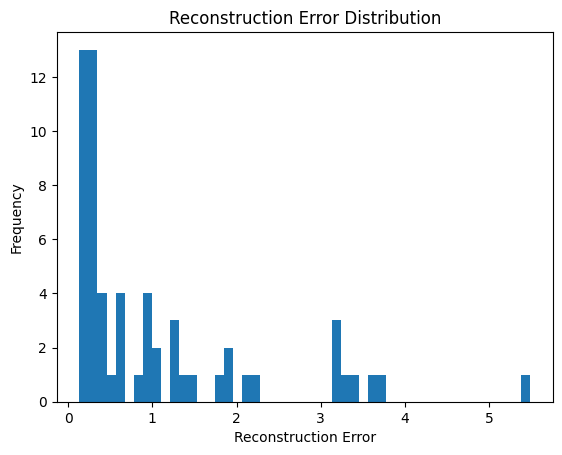

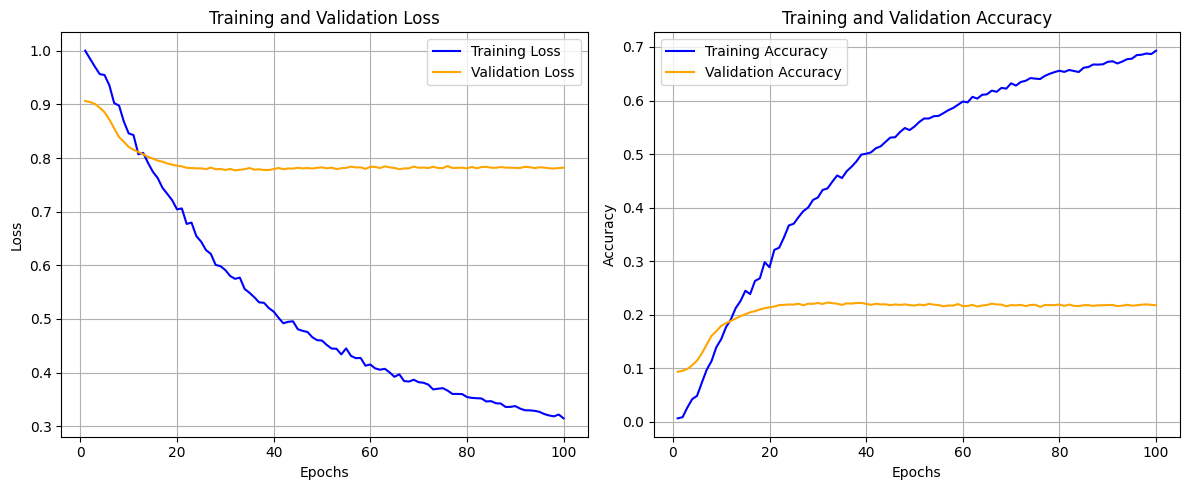

In [37]:
model.eval()
test_loss = 0
reconstruction_errors = []
predictions = []
with torch.no_grad():
    for batch in test_loader:
        # batch = batch.cuda()
        outputs = model(batch)  # Get reconstructed outputs
        loss = criterion(outputs, batch)  # Calculate loss (reconstruction error)
        test_loss += loss.item()
        
        # Calculate reconstruction errors for each sample
        errors = calculate_reconstruction_error(batch, outputs)
        reconstruction_errors.append(errors)

        # Make predictions based on a reconstruction error threshold
        threshold = 0.01  # Set your threshold for normal vs. anomalous
        preds = (errors > threshold).int()  # Predict 1 if error > threshold else 0
        predictions.append(preds)

print(f'Test Loss: {test_loss/len(test_loader)}')

# Concatenate errors and predictions
reconstruction_errors = torch.cat(reconstruction_errors)  # Concatenate errors from batches
predictions = torch.cat(predictions).numpy()  # Convert to numpy for confusion matrix

# Plot reconstruction error
# reconstruction_errors = torch.cat(reconstruction_errors)  # Concatenate errors from batches
plot_reconstruction_error(reconstruction_errors)
# Plot training loss and accuracy
plot_training_history(loss_history, val_loss_history, accuracy_history, val_accuracy_history)

# Calculate and display the confusion matrix
# confusion_mat = confusion_matrix(labels[test_size:], predictions)  # Use actual labels for test data
# ConfusionMatrixDisplay(confusion_mat).plot(cmap='Blues')
# plt.title("Confusion Matrix")
# plt.show()